# Install and load package

In [ ]:
!pip install transformers
!pip install peft
!pip install accelerate
!pip install bitsandbytes
!pip install Sastrawi
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 13.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import nltk
import random
import json
import re
import string
import itertools
import torch

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from peft import PrefixTuningConfig, get_peft_model, TaskType
from torch.utils.data import Dataset

nltk.download('punkt', quiet=True)

True

# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/Tugas Akhir/intent_dataset.json') as file:
    intents = json.load(file)

# Extract data to dataframe

In [ ]:
df = pd.DataFrame(intents['intents'])

In [ ]:
dic = {"tag":[], "patterns":[], "responses":[]}
for i in range(len(df)):
    ptrns = df.loc[i, 'patterns']
    rspns = df.loc[i, 'responses']
    tag = df.loc[i, 'tag']
    for p in ptrns:
        dic['tag'].append(tag)
        dic['patterns'].append(p)
        dic['responses'].append(rspns)

df = pd.DataFrame.from_dict(dic)

# Data Preprocessing

## Make preprocessing function

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stopWordFactory = StopWordRemoverFactory()

In [ ]:
def lower(text):
    return text.lower()

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_punctuation(text):
    remove = string.punctuation.replace("?", "") # Keep question marks
    pattern = r"[{}]\\".format(remove) # Escaped the backslash
    return re.sub(pattern, "", text)

def remove_whitespace_LT(text):
    return text.strip()

def remove_whitespace_multiple(text):
    return re.sub('\\s+',' ',text)

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_angka(text):
    return re.sub(r"\\d+", "", text)

def stopwords(text):
    more_stopword = ['sih', 'nya','rt','loh','lah', 'dd', 'mah', 'nye', 'eh', 'ehh', 'ah', 'yang','yg']
    data = stopWordFactory.get_stop_words()
    data.remove('tidak')
    stopwords_sastrawi = stopWordFactory.create_stop_word_remover()

    dictionary = ArrayDictionary(data+more_stopword)
    str_stopwords = StopWordRemover(dictionary)
    return str_stopwords.remove(text)

def stemming(text):
    return stemmer.stem(text)

## Apply Preprocessing

In [ ]:
processed_patterns = []
for text in df['patterns'].values:
    proc = lower(text)
    proc = non_ascii(proc)
    proc = remove_tab(proc)
    proc = remove_punctuation(proc)
    proc = remove_angka(proc)
    proc = remove_whitespace_LT(proc)
    proc = remove_whitespace_multiple(proc)
    proc = stopwords(proc)
    proc = stemming(proc)
    processed_patterns.append(proc)

df['patterns'] = processed_patterns

## Split data patterns and responses

In [ ]:
df_patterns = df[['tag','patterns']]

In [ ]:
df_responses = df[['tag','responses']]
df_responses['responses'] = df_responses['responses'].apply(lambda x: str(x))
df_responses = df_responses.drop_duplicates().reset_index(drop=True)

/tmp/ipython-input-2778960585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_responses['responses'] = df_responses['responses'].apply(lambda x: str(x))


## Data Balancing with Oversampling

In [ ]:
def balance_data(df):
    max_size = df['tag'].value_counts().max()
    lst = [df]
    for class_index, group in df.groupby('tag'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df_balanced = pd.concat(lst)
    return df_balanced

df_patterns = balance_data(df_patterns)

## Replace labels string with label number

In [ ]:
labels = df_patterns['tag'].unique().tolist()
labels = [s.strip() for s in labels]
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [ ]:
df_patterns['labels'] = df_patterns['tag'].map(lambda x: label2id[x.strip()])

# Training

## Split data into train and test

In [ ]:
X = list(df_patterns['patterns'])

In [ ]:
y = list(df_patterns['labels'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

## PEFT LoRA Model Training

### Tokenize and Load Base Model

In [ ]:
model_name = 'cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Configure Prefix Tuning

In [ ]:
prefix_config = PrefixTuningConfig(
    task_type="SEQ_CLS",
    num_virtual_tokens=50,
    prefix_projection=True
)

In [ ]:
# Wrap the base model with PEFT
peft_model = get_peft_model(model, prefix_config)

In [ ]:
# Print the trainable parameters
peft_model.print_trainable_parameters()

trainable params: 15,258,448 || all params: 126,331,040 || trainable%: 12.0781


In [ ]:
train_encoding = tokenizer(X_train, truncation=True, padding=True, max_length=512)
test_encoding = tokenizer(X_test, truncation=True, padding=True, max_length=512)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

### Build data loader

In [ ]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

### Define Evaluation Metrics

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

### Training Arguments

In [ ]:
output_directory = "/content/drive/MyDrive/Tugas Akhir/prefix tuning/hasil_pelatihan"

training_args = TrainingArguments(
    output_dir=output_directory,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    learning_rate=3e-5,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_Accuracy",
    greater_is_better=False
)

### Train the model

In [ ]:
trainer = Trainer(
    model=peft_model, # Use the PEFT model here
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: neovilletajujung026 (neovilletajujung026-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,6.416400,6.389828,0.000845,0.000038,0.000019,0.000845
200,6.347100,6.326400,0.006757,0.002461,0.001944,0.006757
300,6.298900,6.246800,0.021115,0.011204,0.010782,0.021115
400,6.211000,6.149539,0.048142,0.023233,0.021354,0.048142
500,6.089400,6.032627,0.090372,0.054101,0.048600,0.090372
600,5.986500,5.904051,0.150338,0.107929,0.103183,0.150338
700,5.867000,5.779448,0.230574,0.187034,0.188263,0.230574
800,5.730500,5.655915,0.300676,0.246229,0.248322,0.300676
900,5.644400,5.527824,0.392736,0.329951,0.330700,0.392736
1000,5.525600,5.416759,0.451858,0.391321,0.396936,0.451858


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,6.416400,6.389828,0.000845,0.000038,0.000019,0.000845
200,6.347100,6.326400,0.006757,0.002461,0.001944,0.006757
300,6.298900,6.246800,0.021115,0.011204,0.010782,0.021115
400,6.211000,6.149539,0.048142,0.023233,0.021354,0.048142
500,6.089400,6.032627,0.090372,0.054101,0.048600,0.090372
600,5.986500,5.904051,0.150338,0.107929,0.103183,0.150338
700,5.867000,5.779448,0.230574,0.187034,0.188263,0.230574
800,5.730500,5.655915,0.300676,0.246229,0.248322,0.300676
900,5.644400,5.527824,0.392736,0.329951,0.330700,0.392736
1000,5.525600,5.416759,0.451858,0.391321,0.396936,0.451858


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=14800, training_loss=2.1291292874877517, metrics={'train_runtime': 2449.9397, 'train_samples_per_second': 193.311, 'train_steps_per_second': 6.041, 'total_flos': 5903054910259200.0, 'train_loss': 2.1291292874877517, 'epoch': 100.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.366326,0.965160,0.963173,0.970159,0.965160
test,0.559386,0.922297,0.910433,0.916892,0.922297


### Visualisasi hasil pelatihan


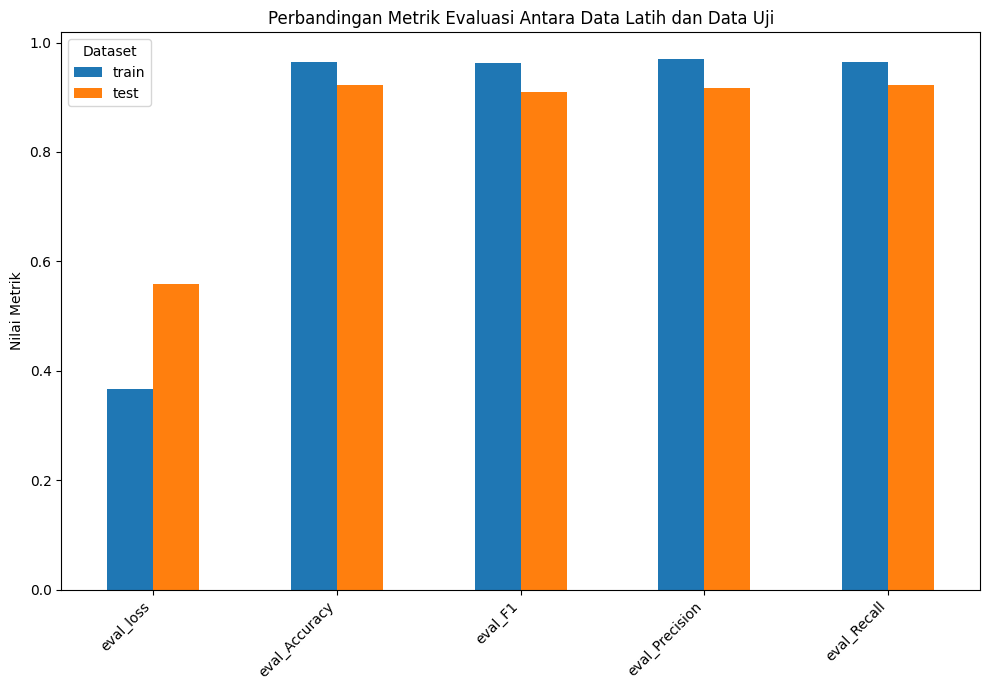

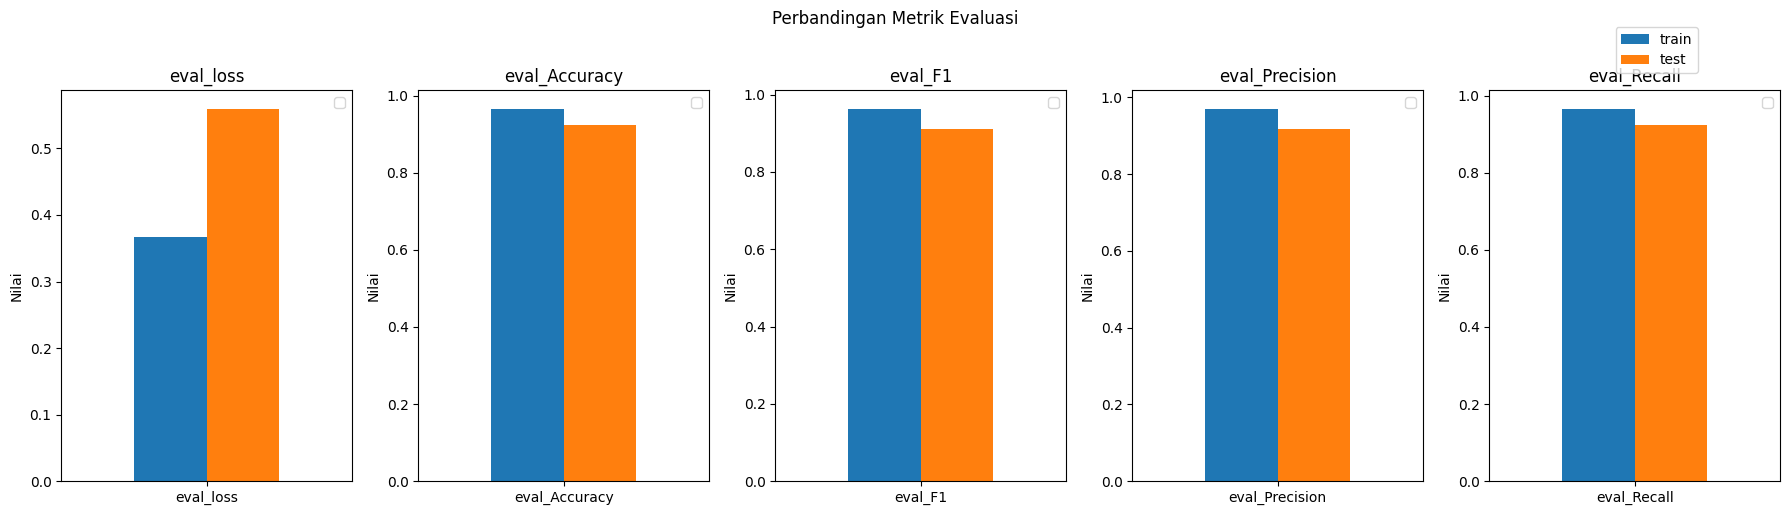

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

eval_results_df = pd.DataFrame(q, index=["train", "test"])

# Select the columns we want to visualize
metrics_to_visualize = ['eval_loss', 'eval_Accuracy', 'eval_F1', 'eval_Precision', 'eval_Recall']
eval_metrics_subset = eval_results_df[metrics_to_visualize]

# Plotting using pandas plot function
eval_metrics_subset.T.plot(kind='bar', figsize=(10, 7))
plt.title('Perbandingan Metrik Evaluasi Antara Data Latih dan Data Uji')
plt.ylabel('Nilai Metrik')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Another way to visualize: separate plots for each metric
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_visualize), figsize=(18, 5))
fig.suptitle('Perbandingan Metrik Evaluasi', y=1.02)

for i, metric in enumerate(metrics_to_visualize):
    eval_results_df[[f'eval_{metric.split("_")[-1]}']].T.plot(kind='bar', ax=axes[i]) # Correct column name
    axes[i].set_title(metric)
    axes[i].set_ylabel('Nilai')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].legend([]) # Remove individual legends, use suptitle

# Add a single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 1.0))

plt.tight_layout()
plt.show()

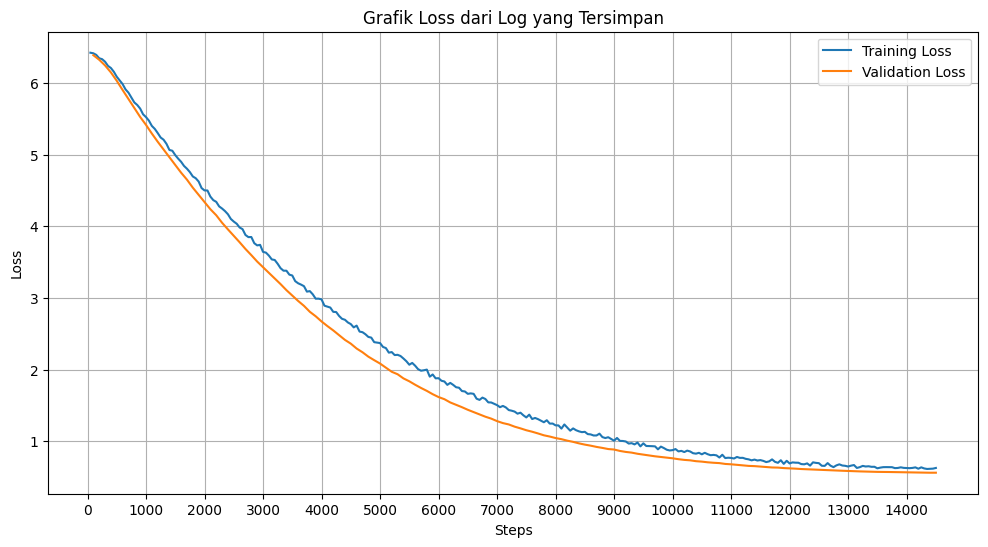

In [32]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Arahkan ke folder tempat log disimpan
log_folder = "/content/drive/MyDrive/Tugas Akhir/prefix tuning/hasil_pelatihan"

# Temukan file log di dalam folder checkpoint (biasanya trainer_state.json)
# Anda mungkin perlu menyesuaikan path ini tergantung pada struktur folder checkpoint
log_file_path = f"{log_folder}/checkpoint-14500/trainer_state.json" # Contoh path

# Muat data log
with open(log_file_path, 'r') as f:
    data = json.load(f)

log_history = data['log_history']

# Proses data log menjadi DataFrame (sama seperti kode sebelumnya)
train_logs = pd.DataFrame([log for log in log_history if 'loss' in log])
eval_logs = pd.DataFrame([log for log in log_history if 'eval_loss' in log])

# Membuat visualisasi grafik (sama seperti kode sebelumnya)
plt.figure(figsize=(12, 6))
plt.plot(train_logs["step"], train_logs["loss"], label="Training Loss")
plt.plot(eval_logs["step"], eval_logs["eval_loss"], label="Validation Loss")
plt.title("Grafik Loss dari Log yang Tersimpan")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Set x-axis ticks to show every 1000 steps
max_step = max(train_logs["step"].max(), eval_logs["step"].max())
plt.xticks(np.arange(0, max_step + 1, 1000))

plt.show()

In [39]:
model_path = "/content/drive/MyDrive/Tugas Akhir/prefix tuning"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/Tugas Akhir/prefix tuning/tokenizer_config.json',
 '/content/drive/MyDrive/Tugas Akhir/prefix tuning/special_tokens_map.json',
 '/content/drive/MyDrive/Tugas Akhir/prefix tuning/vocab.txt',
 '/content/drive/MyDrive/Tugas Akhir/prefix tuning/added_tokens.json')

### Chat with Final Chatbot

In [40]:
from transformers import pipeline
from peft import PeftModel

# Define the base model name and the path to the trained adapter
model_name = 'cahya/bert-base-indonesian-522M'
model_path = "/content/drive/MyDrive/Tugas Akhir/prefix tuning"


# Load base model from cahya/bert-base-indonesian-522M
base_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

# Load the trained PEFT adapter model from the specified path
peft_trained_model = PeftModel.from_pretrained(base_model, model_path)

# Load tokenizer from the saved path (which contains the adapter model and tokenizer)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Create pipeline using the PEFT trained model
chatbot = pipeline("text-classification", model=peft_trained_model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


In [44]:
import ast # Import the ast module

def preprocessing_user_input(text):
    proc = lower(text)
    proc = non_ascii(proc)
    proc = remove_tab(proc)
    proc = remove_punctuation(proc)
    proc = remove_angka(proc)
    proc = remove_whitespace_LT(proc)
    proc = remove_whitespace_multiple(proc)
    proc = stopwords(proc)
    proc = stemming(proc)
    return proc

def chat(chatbot_pipeline):
    print("Chatbot: Hai! Saya RISELF, Teman cerita Virtual Anda. Jangan ragu untuk bercerita, saya akan berusaha membantu")
    print("Ketik 'quit' untuk keluar dari chat\n\n")

    while True:
        text_input = input("User: ").strip()
        if text_input.lower() == 'quit':
            print("Chatbot: Sampai jumpa lagi!")
            break

        processed_text = preprocessing_user_input(text_input)

        if not processed_text:
            print("Chatbot: Maaf, saya tidak mengerti. Bisa coba kalimat lain?\n\n")
            continue

        prediction = chatbot_pipeline(processed_text)[0]
        score = prediction['score']
        predicted_label_str = prediction['label']

        if score < 0.2: # Confidence threshold
            print(f"Chatbot: Terima kasih sudah berbagi. Saya sedang berusaha memahami. Jika Anda merasa kesulitan, mungkin berbicara dengan profesional bisa sangat membantu. Mereka punya keahlian khusus untuk mendampingi Anda. Saya di sini untuk mendengarkan kapan pun Anda butuh.")
        else:
            # Get random response from detected intent
            response_options_str = df_responses[df_responses['tag'] == predicted_label_str]['responses'].iloc[0]
            # Convert the string representation of the list to an actual list
            response_options = ast.literal_eval(response_options_str)
            response = random.choice(response_options)
            print(score)
            print(text_input)
            print(f"Chatbot: {response}\n\n")

In [45]:
chat(chatbot)

Chatbot: Hai! Saya RISELF, Teman cerita Virtual Anda. Jangan ragu untuk bercerita, saya akan berusaha membantu
Ketik 'quit' untuk keluar dari chat


User: halo
0.3776875138282776
halo
Chatbot: Senang bertemu denganmu, {user_name}. Bagaimana kabarmu hari ini? Ingat, tidak ada perasaan yang salah di sini, jadi jangan ragu untuk jujur pada dirimu sendiri. 🌱


User: selamat pagi
0.7810171842575073
selamat pagi
Chatbot: Selamat pagi, {user_name}! Aku harap tidurmu semalam nyenyak dan membawa sedikit kelegaan. Apa yang ingin kamu bagikan di pagi yang baru ini? ☀️




KeyboardInterrupt: Interrupted by user